# Predicting Gym Attendance with SGD, XGBoost, and Ensemble Methods

## Table of Contents

- [1. Introduction](#1.-Introduction)
- [2. Exploring and Cleaning the Data](#2.-Exploring-and-Cleaning-the-Data)
- [3. Building and Evaluating the SGD Models](#3.-Building-and-Evaluating-the-SGD-Models)
- [4. Visualizing the Results of the SGD Models](#4.-Visualizing-the-Results-of-the-SGD-Models)
- [5. Evaluating Performance Across Multiple Models](#5.-Evaluating-Performance-Across-Multiple-Models)
- [6. Conclusion](#6.-Conclusion)

## 1. Introduction

Many people love going to the gym, but dislike arriving only to find it so crowded that they have to wait to use the machines they need for their exercises. In this project, our task is to use the `Crowdedness at the Campus Gym` dataset, which contains historical information about the gym's occupancy on different days and at different hours, as well as other specific details.

We'll build two versions of the SGD linear regression model and incorporate additional models, including ensemble methods, to improve predictions. Our goal is to predict the number of people at the gym on a given day at a specific time based on the input features. By doing this, we aim to determine the best times to visit the gym to avoid crowds, ensuring a great workout with minimal wait times. Finally, we will evaluate the models and visualize some of the results.

The dataset contains over `60,000` observations of gym occupancy by day and time, with `11` columns as follows:
- `number_people` – Number of people at the gym.
- `date` – Date and time as a string.
- `timestamp` – Seconds since the start of the day (`00:00`).
- `dayofweek` – Day of the week as an integer (`0=Monday`, `6=Sunday`).
- `is_weekend` – Boolean indicating if it's a weekend (`1=Yes`, `0=No`).
- `is_holiday` – Boolean indicating if it's a holiday (`1=Yes`, `0=No`).
- `temperature` – Temperature in Fahrenheit.
- `isstartof_semester` – Boolean indicating if it’s within the first `2` weeks of a semester (`1=Yes`, `0=No`).
- `is_during_semester` – Boolean indicating if it’s during an active semester (`1=Yes`, `0=No`).
- `month` – Month of the year as an integer (`1=January`, `12=December`).
- `hour` – Hour of the day from `0` to `23`.

Next, let’s import the necessary libraries and load the CSV file.

In [1]:
# Import the relevant libraries
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
import xgboost as xgb

import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np

# Load the gym dataset and display the first 3 rows
gym = pd.read_csv('Datasets/crowdness_gym_data.csv')
gym.head(3)

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17


The first `3` rows of the dataset indicate that on `August 14, 2015`, a `Friday`, the gym had `37`, `45`, and `40` people at `5:00 PM`, `5:20 PM`, and `5:30 PM`, respectively. The temperature was `71.76°F`, it wasn't a weekend or holiday, and it was outside the start and active semester periods. Moreover, the timestamp values suggest the gym's activity was being tracked at regular intervals.

In [2]:
# Display summary information about the dataset
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         62184 non-null  int64  
 1   date                  62184 non-null  object 
 2   timestamp             62184 non-null  int64  
 3   day_of_week           62184 non-null  int64  
 4   is_weekend            62184 non-null  int64  
 5   is_holiday            62184 non-null  int64  
 6   temperature           62184 non-null  float64
 7   is_start_of_semester  62184 non-null  int64  
 8   is_during_semester    62184 non-null  int64  
 9   month                 62184 non-null  int64  
 10  hour                  62184 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 5.2+ MB


The dataset contains `62,184` entries with `11` columns. Most columns are integers, except for one float (`temperature`) and one string (`date`). Also, the data is complete with no missing values.

In [3]:
# Display statistical summary of the dataset
gym.describe()

,number_people,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
count,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000
mean,29.072543,45799.437958,2.982504,0.282870,0.002573,58.557108,0.078831,0.660218,7.439824,12.236460
std,22.689026,24211.275891,1.996825,0.450398,0.050660,6.316396,0.269476,0.473639,3.445069,6.717631
min,0.000000,0.000000,0.000000,0.000000,0.000000,38.140000,0.000000,0.000000,1.000000,0.000000
25%,9.000000,26624.000000,1.000000,0.000000,0.000000,55.000000,0.000000,0.000000,5.000000,7.000000
50%,28.000000,46522.500000,3.000000,0.000000,0.000000,58.340000,0.000000,1.000000,8.000000,12.000000
75%,43.000000,66612.000000,5.000000,1.000000,0.000000,62.280000,0.000000,1.000000,10.000000,18.000000
max,145.000000,86399.000000,6.000000,1.000000,1.000000,87.170000,1.000000,1.000000,12.000000,23.000000


Here are some insights based on the table above:
- The dataset shows that gym attendance averages around `29` people, with significant variation, ranging from `0` to `145`. 
- The mean of `is_weekend` indicates that about `28.29%` of the observations in the dataset were recorded on weekends. The data is skewed toward non-weekends and non-holidays, with temperatures ranging from `38.14°F` to `87.17°F`.
- The gym is more often observed during the semester than at the start of it.
- Furthermore, observations are spread throughout the day, with timestamps covering the full `24-hour` range.

## 2. Exploring and Cleaning the Data

To ensure we have the necessary data while removing any noisy or irrelevant information, we need to thoroughly explore the dataset, create visualizations, and determine which features to keep, discarding those that are not useful.

Since the `date` column is stored as an object, and we already have other features that specify the day and time, we will remove this column entirely.

In [4]:
# Remove the 'date' column and display the remaining column names
gym = gym.drop('date', axis=1)
gym.columns

Index(['number_people', 'timestamp', 'day_of_week', 'is_weekend', 'is_holiday',
       'temperature', 'is_start_of_semester', 'is_during_semester', 'month',
       'hour'],
      dtype='object')

Now, we'll plot histograms for the month, day, and hour, as these factors likely have the greatest influence on the number of people.

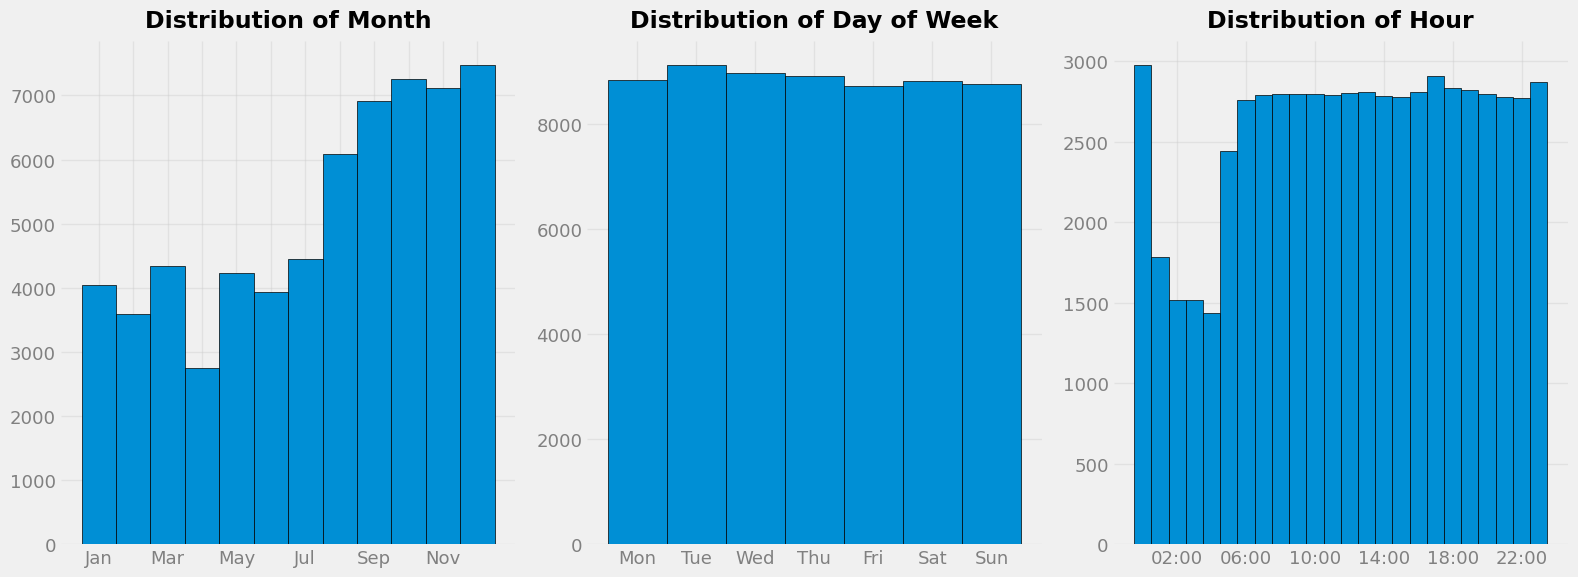

In [5]:
# Set the style to FiveThirtyEight
plt.style.use('fivethirtyeight')

# Create subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

# Plot histogram for 'month'
axs[0].hist(gym['month'], bins=range(1, 14), edgecolor='black')
axs[0].set_title('Distribution of Month', weight='bold', size=17, pad=10)
axs[0].set_xticks([i+0.5 for i in range(1, 13)])
axs[0].set_xticklabels(['Jan', '', 'Mar', '', 'May', '', 'Jul', '', 'Sep', '', 'Nov', ''])

# Plot histogram for 'day_of_week'
axs[1].hist(gym['day_of_week'], bins=range(8), edgecolor='black')
axs[1].set_title('Distribution of Day of Week', weight='bold', size=17, pad=10)
axs[1].set_xticks([i+0.5 for i in range(7)])
axs[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Plot histogram for 'hour'
axs[2].hist(gym['hour'], bins=range(25), edgecolor='black')
axs[2].set_title('Distribution of Hour', weight='bold', size=17, pad=10)
axs[2].set_xticks([i+0.5 for i in range(2, 24, 4)])
axs[2].set_xticklabels([f'{i:02d}:00' for i in range(2, 24, 4)])

# Apply common styling and remove plot spines
for ax in axs:
    ax.tick_params(colors='grey', labelsize=13)
    ax.set_ylabel('')
    ax.grid(alpha=0.4)
    for spine in ax.spines.values():
        spine.set_visible(False)

# Adjust layout to prevent overlap and display the plot
plt.tight_layout()
plt.show()

As we can see, the months in the last quarter of the year have the most observations, particularly `December`. Weekly patterns show that `Tuesday` has the highest number of entries, though the counts remain consistent for the other days of the week. Additionally, the hourly data indicates that midnight has the most observations; the number of entries gradually decreases for the subsequent hours before starting to increase again after `5:00 AM`, stabilizing during the early morning and late evening hours.

We can gain more insights by using **bivariate** rather than **univariate** analysis, which allows us to examine the relationship between two variables simultaneously. Let's plot the relationships between month, day, and hour in relation to the number of people.

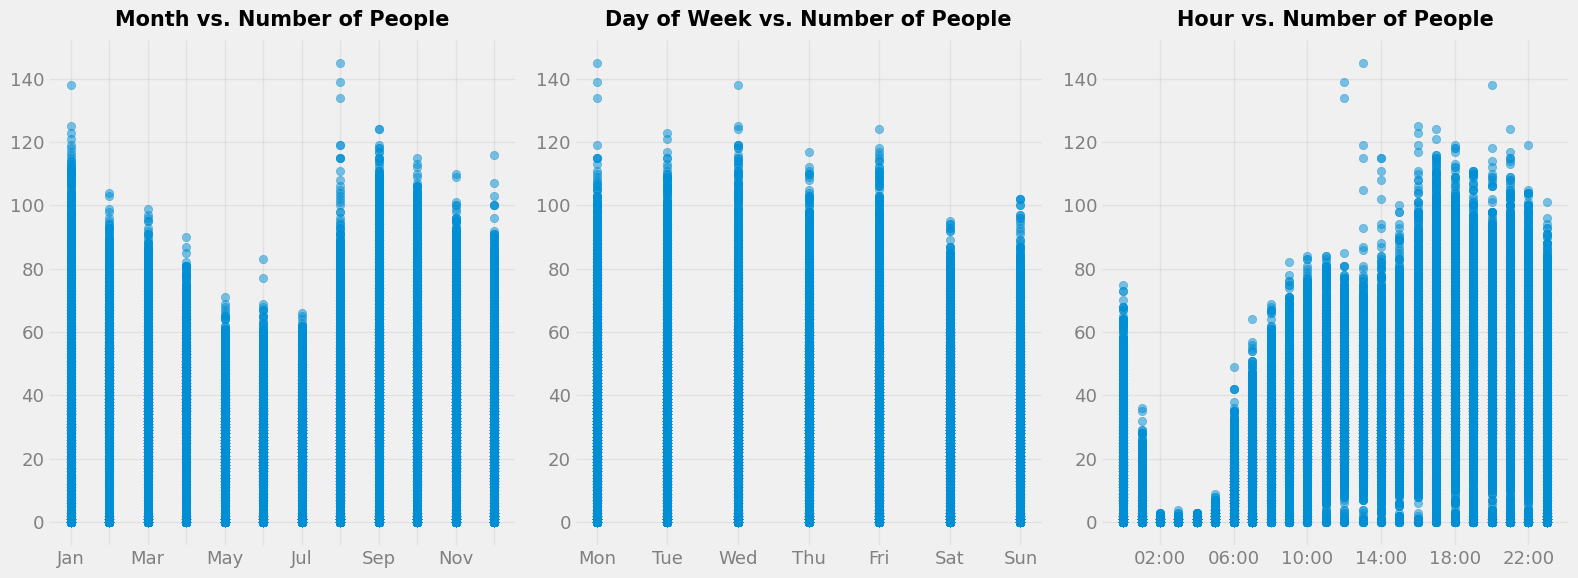

In [6]:
# Create subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

# Scatter plot for 'month' vs 'number_people'
axs[0].scatter(gym['month'], gym['number_people'], alpha=0.5)
axs[0].set_title('Month vs. Number of People', weight='bold', size=15, pad=10)
axs[0].set_xticks([i for i in range(1, 13)])
axs[0].set_xticklabels(['Jan', '', 'Mar', '', 'May', '', 'Jul', '', 'Sep', '', 'Nov', ''])

# Scatter plot for 'day_of_week' vs 'number_people'
axs[1].scatter(gym['day_of_week'], gym['number_people'], alpha=0.5)
axs[1].set_title('Day of Week vs. Number of People', weight='bold', size=15, pad=10)
axs[1].set_xticks([i for i in range(7)])
axs[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Scatter plot for 'hour' vs 'number_people'
axs[2].scatter(gym['hour'], gym['number_people'], alpha=0.5)
axs[2].set_title('Hour vs. Number of People', weight='bold', size=15, pad=10)
axs[2].set_xticks([i for i in range(2, 24, 4)])
axs[2].set_xticklabels([f'{i:02d}:00' for i in range(2, 24, 4)])

# Apply common styling and remove plot spines
for ax in axs:
    ax.tick_params(colors='grey', labelsize=13)
    ax.set_ylabel('')
    ax.grid(alpha=0.4)
    for spine in ax.spines.values():
        spine.set_visible(False)

# Adjust layout to prevent overlap and display the plot
plt.tight_layout()
plt.show()

The scatter plots display the relationship between gym occupancy and three different variables:

* From the `Month vs. Number of People` plot, gym occupancy peaks at certain times of the year, notably in `January` and `September`, likely due to New Year's resolutions and the start of the fall semester. Mid-year months such as `July` show lower occupancy, possibly due to vacations.
* The `Day of Week vs. Number of People` plot shows consistent high occupancy throughout the weekdays (`Monday` to `Friday`), with a noticeable dip on `Saturdays`, reflecting a typical weekly pattern where gym attendance is higher during the workweek.
* Finally, the `Hour vs. Number of People` plot reveals that gym usage is minimal during early morning hours, gradually increasing throughout the day, peaking in the evening between `5 PM` and `9 PM`, which aligns with typical after-work hours, and then tapering off at night.

Next, we will examine the correlation between each variable and our target, which represents the number of people on a given day at a specific time.

In [7]:
# Display correlation of each feature with the target variable ('number_people')
gym.corr().iloc[0, 1:]

timestamp               0.550218
day_of_week            -0.162062
is_weekend             -0.173958
is_holiday             -0.048249
temperature             0.373327
is_start_of_semester    0.182683
is_during_semester      0.335350
month                  -0.097854
hour                    0.552049
Name: number_people, dtype: float64

The strongest positive correlations with gym attendance are with `hour` (`0.55`) and `timestamp` (`0.55`), indicating higher attendance with later hours and time progress. Additionally, `temperature` and `is_during_semester` have moderate positive correlations, while `is_start_of_semester` has a weak positive correlation. Conversely, `day_of_week`, `is_weekend`, `is_holiday`, and `month` show weak negative correlations.

Based on our analysis, we consider `hour`, `temperature`, and `is_during_semester` as the most important variables. Additionally, `timestamp` appears redundant, as it has a nearly identical correlation to `hour`. Given that we have time-related information in `month`, `day_of_week`, and `hour`, we will omit the `timestamp` column before proceeding with model building.

In [8]:
# Drop the 'timestamp' column and display remaining columns
gym = gym.drop('timestamp', axis=1)
gym.columns

Index(['number_people', 'day_of_week', 'is_weekend', 'is_holiday',
       'temperature', 'is_start_of_semester', 'is_during_semester', 'month',
       'hour'],
      dtype='object')

## 3. Building and Evaluating the SGD Models

Now that we have a clean dataset and removed variables we deem unimportant or too noisy, it's time to prepare the data for two versions of the SGD model. First, we need to split the data into training and testing sets, using `80%` for training and `20%` for testing. We will also set a random state to ensure reproducibility in future analyses.

In [9]:
# Convert the DataFrame to a NumPy array, and separate features (X) and target variable (y)
data = gym.values
X = data[:, 1:]
y = data[:, 0]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Print the shapes of the training and testing sets
print(f"Training features shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Testing target shape: {y_test.shape}")

Training features shape: (49747, 8)
Training target shape: (49747,)
Testing features shape: (12437, 8)
Testing target shape: (12437,)


The dataset has `49,747` samples with `8` features for training, and `12,437` samples with `8` features for testing. Obviously, the target variable is a single column for both training and testing sets.

Next, once we've trained the first version of the SGD model, we're going to measure its performance using the following metrics: `root_mean_squared_error`, `mean_absolute_error`, and `r2_score`.

In [10]:
# Initialize and train the first version of the SGDRegressor model with specified hyperparameters
sgd_v1 = SGDRegressor(alpha=0.01, eta0=0.001, max_iter=1000, random_state=42,
                      penalty='elasticnet', loss='squared_error', learning_rate='invscaling')
sgd_v1.fit(X_train, y_train)

# Predict with the SGDRegressor on train data and evaluate using RMSE, MAE, and R²
y_pred_v1_train = sgd_v1.predict(X_train)
print(f"Train Data Metrics:")
print(f"Root mean squared error: {root_mean_squared_error(y_train, y_pred_v1_train):.2f}")
print(f"Mean absolute error: {mean_absolute_error(y_train, y_pred_v1_train):.2f}")
print(f"R-squared score: {r2_score(y_train, y_pred_v1_train):.4f}")

# Predict with the SGDRegressor on test data and evaluate using RMSE, MAE, and R²
y_pred_v1_test = sgd_v1.predict(X_test)
print(f"\nTest Data Metrics:")
print(f"Root mean squared error: {root_mean_squared_error(y_test, y_pred_v1_test):.2f}")
print(f"Mean absolute error: {mean_absolute_error(y_test, y_pred_v1_test):.2f}")
print(f"R-squared score: {r2_score(y_test, y_pred_v1_test):.4f}")

Train Data Metrics:
Root mean squared error: 16.48
Mean absolute error: 12.41
R-squared score: 0.4717

Test Data Metrics:
Root mean squared error: 16.41
Mean absolute error: 12.34
R-squared score: 0.4789


The first version of the SGD model shows a root mean squared error (RMSE) of `16.41` and a mean absolute error (MAE) of `12.34` on the test data, indicating that the average absolute difference between the predicted and actual gym attendance is `12.34` units, with larger errors impacting the RMSE. Moreover, the test R-squared score of `0.4789` suggests that approximately `47.89%` of the variance in the target variable is explained by the model, indicating moderate predictive power. Since the train and test metrics are very similar, this suggests that the model did not overfit.

For the second version of SGD, we will scale the features to normalize them from `-1` to `1`, which may help enhance the model's performance. Additionally, we will apply the same random state of `42` for consistent results.

In [11]:
# Initialize and fit the scaler using the training features
scaler = StandardScaler()
scaler.fit(X_train)

# Transform both training and testing features
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the second version of the SGDRegressor model with specified hyperparameters
sgd_v2 = SGDRegressor(alpha=0.01, eta0=0.001, max_iter=1000, random_state=42,
                      penalty='elasticnet', loss='squared_error', learning_rate='invscaling')
sgd_v2.fit(X_train_scaled, y_train)

# Predict with the SGDRegressor on train data and evaluate using RMSE, MAE, and R²
y_pred_v2_train = sgd_v2.predict(X_train_scaled)
print(f"Train Data Metrics:")
print(f"Root mean squared error: {root_mean_squared_error(y_train, y_pred_v2_train):.2f}")
print(f"Mean absolute error: {mean_absolute_error(y_train, y_pred_v2_train):.2f}")
print(f"R-squared score: {r2_score(y_train, y_pred_v2_train):.4f}")

# Predict with the SGDRegressor on test data and evaluate using RMSE, MAE, and R²
y_pred_v2_test = sgd_v2.predict(X_test_scaled)
print(f"\nTest Data Metrics:")
print(f"Root mean squared error: {root_mean_squared_error(y_test, y_pred_v2_test):.2f}")
print(f"Mean absolute error: {mean_absolute_error(y_test, y_pred_v2_test):.2f}")
print(f"R-squared score: {r2_score(y_test, y_pred_v2_test):.4f}")

Train Data Metrics:
Root mean squared error: 15.91
Mean absolute error: 12.18
R-squared score: 0.5075

Test Data Metrics:
Root mean squared error: 15.84
Mean absolute error: 12.09
R-squared score: 0.5147


After normalizing our features, the mean absolute error decreased from `12.34` to `12.09`, and the root mean squared error decreased from `16.41` to `15.84` on the test data, indicating relatively smaller and less impactful errors. Additionally, the R-squared score increased from `0.4789` to `0.5147`, demonstrating a better fit to the data.

Since the train and test metrics are very similar, with the test metrics being marginally better, this suggests that the second version of the SGD model didn't overfit as well.

## 4. Visualizing the Results of the SGD Models

A good way to understand and evaluate our models is to visualize their results. We can plot the predictions of both SGD linear regression models against the actual test data using line plots, with the actual data as the background and the predicted data overlaid. Where the plots converge, the model performed well; where they diverge, the model performed poorly.

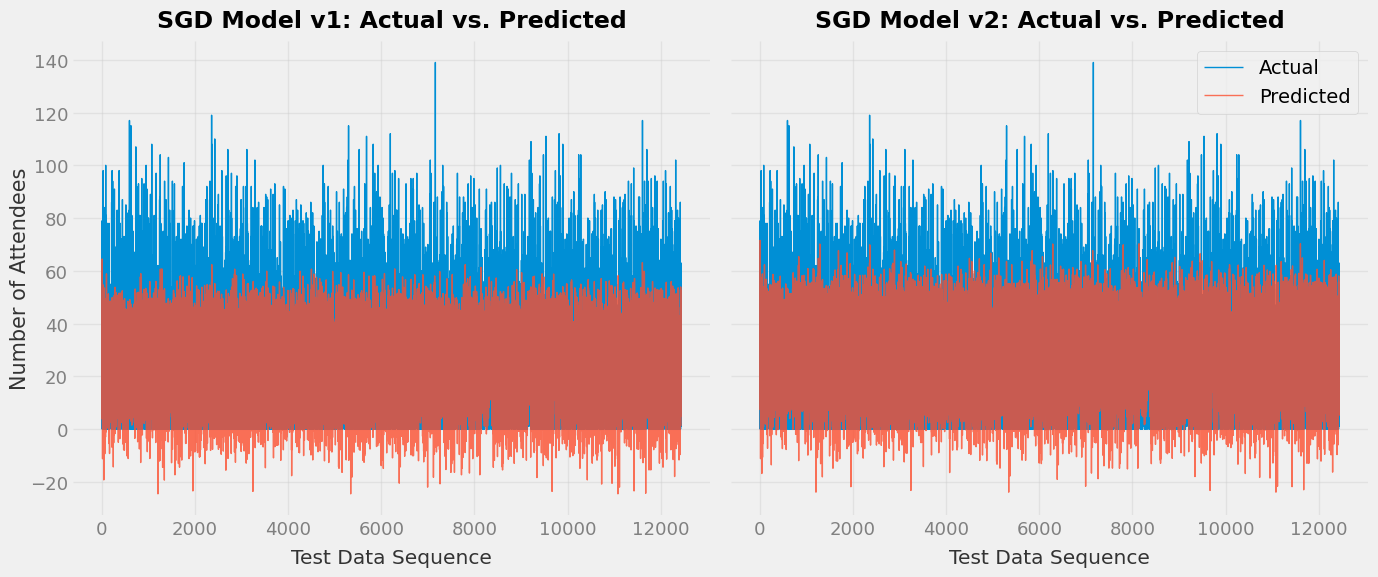

In [12]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Make a line plot for the first SGD model
axs[0].plot(range(len(y_test)), y_test, linewidth=1, label="Actual")
axs[0].plot(range(len(y_test)), y_pred_v1_test, linewidth=1, label="Predicted", alpha=0.8)
axs[0].set_title('SGD Model v1: Actual vs. Predicted', weight='bold', size=17, pad=10)
axs[0].set_ylabel('Number of Attendees', c='#333333', labelpad=0, size=15)
axs[0].set_xlabel('Test Data Sequence', c='#333333', labelpad=7, size=14.5)

# Make a line plot for the second SGD model
axs[1].plot(range(len(y_test)), y_test, linewidth=1, label="Actual")
axs[1].plot(range(len(y_test)), y_pred_v2_test, linewidth=1, label="Predicted", alpha=0.8)
axs[1].set_title('SGD Model v2: Actual vs. Predicted', weight='bold', size=17, pad=10)
axs[1].set_xlabel('Test Data Sequence', c='#333333', labelpad=7, size=14.5)
axs[1].set_ylabel('')
axs[1].legend()

# Apply common styling and remove plot spines
for ax in axs:
    ax.tick_params(colors='grey', labelsize=13)
    ax.grid(alpha=0.4)
    for spine in ax.spines.values():
        spine.set_visible(False)

# Adjust layout to prevent overlap and display the plot
plt.tight_layout()
plt.show()

As we can see, both versions of the SGD model struggle to accurately capture the peaks and variations in gym attendance, consistently underestimating the number of people at the gym. In other words, the predicted values for both models are consistently lower and less variable than the actual test data. Surprisingly, some of the predictions fall below zero, which is illogical since the number of gym attendees should always be non-negative.

Although the predictions from model `v2` are marginally better than those from model `v1`, the divergence in both cases indicates that further refinement is needed to improve the models' performance in predicting gym occupancy. While a linear regression model using stochastic gradient descent provides a solid starting point, we will train new models, including ensemble methods, to enhance predictions.

## 5. Evaluating Performance Across Multiple Models

First, we will train an optimized XGBoost model using the specified parameters, which were obtained through multiple trials. Afterward, we will evaluate the model’s performance on both the training and test data using the same metrics as we did for the SGD models, while also utilizing scaled features.

In [13]:
# Initialize and train the optimized XGBoost model with specified hyperparameters
xgb_model = xgb.XGBRegressor(colsample_bytree=1.0, learning_rate=0.2, max_depth=10,
                             gamma=0.1, subsample=1.0, n_estimators=200, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Make predictions on the training and test sets
y_train_pred_xgb = xgb_model.predict(X_train_scaled)
y_test_pred_xgb = xgb_model.predict(X_test_scaled)

# Print performance metrics for the training data
print("Train Data Metrics:")
print(f"Root mean squared error: {root_mean_squared_error(y_train, y_train_pred_xgb):.2f}")
print(f"Mean absolute error: {mean_absolute_error(y_train, y_train_pred_xgb):.2f}")
print(f"R-squared score: {r2_score(y_train, y_train_pred_xgb):.4f}")

# Print performance metrics for the test data
print("\nTest Data Metrics:")
print(f"Root mean squared error: {root_mean_squared_error(y_test, y_test_pred_xgb):.2f}")
print(f"Mean absolute error: {mean_absolute_error(y_test, y_test_pred_xgb):.2f}")
print(f"R-squared score: {r2_score(y_test, y_test_pred_xgb):.4f}")

Train Data Metrics:
Root mean squared error: 5.14
Mean absolute error: 3.48
R-squared score: 0.9486

Test Data Metrics:
Root mean squared error: 6.43
Mean absolute error: 4.37
R-squared score: 0.9201


The optimized XGBoost model significantly outperforms both versions of the SGD model, with lower RMSE and MAE on both the train and test data. The R-squared score for XGBoost shows a significantly better fit, explaining about `94.86%` of the variance in the training data and `92.01%` in the test data. However, the higher RMSE and MAE, along with the lower R² score on the test data compared to the training data for the XGBoost model, suggest minimal overfitting.

Next, we'll train a Voting Regression model that combines Random Forest, Gradient Boosting, and XGBoost, each optimized with specific parameters. Afterward, we'll evaluate the Voting Regression model’s performance on both the training and test data.

In [14]:
# Initialize the optimized Random Forest, Gradient Boosting, and XGBoost models with specified hyperparameters
rf = RandomForestRegressor(n_estimators=200, random_state=42)
gbr = GradientBoostingRegressor(max_depth=7, min_samples_split=5, learning_rate=0.2, n_estimators=200, random_state=42)
xgb_model = xgb.XGBRegressor(max_depth=7, subsample=0.8, learning_rate=0.2, n_estimators=200, random_state=42)

# Create a Voting Regression model with the optimized models
vreg_model = VotingRegressor(estimators=[('rf', rf), ('gbr', gbr), ('xgb', xgb_model)])
vreg_model.fit(X_train_scaled, y_train)

# Make predictions on the training and test data using the Voting Regression model
y_train_pred_vreg = vreg_model.predict(X_train_scaled)
y_test_pred_vreg = vreg_model.predict(X_test_scaled)

# Print performance metrics for the training data
print("Train Data Metrics:")
print(f"Root mean squared error: {root_mean_squared_error(y_train, y_train_pred_vreg):.2f}")
print(f"Mean absolute error: {mean_absolute_error(y_train, y_train_pred_vreg):.2f}")
print(f"R-squared score: {r2_score(y_train, y_train_pred_vreg):.4f}")

# Print performance metrics for the test data
print("\nTest Data Metrics:")
print(f"Root mean squared error: {root_mean_squared_error(y_test, y_test_pred_vreg):.2f}")
print(f"Mean absolute error: {mean_absolute_error(y_test, y_test_pred_vreg):.2f}")
print(f"R-squared score: {r2_score(y_test, y_test_pred_vreg):.4f}")

Train Data Metrics:
Root mean squared error: 5.78
Mean absolute error: 4.05
R-squared score: 0.9351

Test Data Metrics:
Root mean squared error: 6.73
Mean absolute error: 4.73
R-squared score: 0.9124


The Voting Regression model's performance is very similar but slightly lower than the XGBoost model, with higher RMSE and MAE on both the training and test data. The Voting Regression model's lower R-squared score on both sets indicates that it explains slightly less variance. Overall, while the model still demonstrates strong predictive power with minimal overfitting, XGBoost alone is a better fit for this dataset than the combined models.

Now, we'll train an optimized Random Forest model using the specified parameters. Afterward, we'll evaluate the model’s performance on both the training and test data.

In [15]:
# Initialize and train the optimized Random Forest model with specified hyperparameters
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)

# Make predictions on the training and test data
y_train_pred_rf = rf.predict(X_train_scaled)
y_test_pred_rf = rf.predict(X_test_scaled)

# Print training data metrics to evaluate model performance
print("Train Data Metrics:")
print(f"Root mean squared error: {root_mean_squared_error(y_train, y_train_pred_rf):.2f}")
print(f"Mean absolute error: {mean_absolute_error(y_train, y_train_pred_rf):.2f}")
print(f"R-squared score: {r2_score(y_train, y_train_pred_rf):.4f}")

# Print test data metrics to evaluate model performance
print("\nTest Data Metrics:")
print(f"Root mean squared error: {root_mean_squared_error(y_test, y_test_pred_rf):.2f}")
print(f"Mean absolute error: {mean_absolute_error(y_test, y_test_pred_rf):.2f}")
print(f"R-squared score: {r2_score(y_test, y_test_pred_rf):.4f}")

Train Data Metrics:
Root mean squared error: 4.83
Mean absolute error: 3.27
R-squared score: 0.9546

Test Data Metrics:
Root mean squared error: 6.23
Mean absolute error: 4.23
R-squared score: 0.9248


The optimized Random Forest model demonstrates the best performance among the models tested, with the lowest RMSE and MAE values on both the training and test data. Moreover, the R² achieves the highest scores on both sets, explaining approximately `92.48%` of the variance in the test data. While the performance on the test data is slightly lower, the Random Forest model doesn't rely too heavily on the specific details of the training data.

## 6. Conclusion

In this project, we used a dataset containing historical occupancy data from a campus gym, including day, time, and other specific details. Our goal was to predict gym attendance on a given day at a specific time to help identify the least crowded times for a workout. Initially, the dataset contained `62,184` observations across `11` columns, with no missing values and most data in integer format. We also displayed a statistical summary of the dataset and extracted some insights.

To further explore the dataset, we plotted histograms for the month, day, and hour, as we deemed these factors likely to have the most influence on gym attendance. We also created scatter plots showing the relationship between these variables and the number of attendees. Next, we examined correlations with the target variable, `number_people`, identifying `hour`, `temperature`, and `is_during_semester` as key variables. Since `timestamp` had a similar correlation to `hour`, and we already had time-related features, we removed the `timestamp` and `date` columns.

After cleaning the data, we split it into training (`80%`) and testing (`20%`) sets. We trained all models and measured their performance using root mean squared error, mean absolute error, and R² score, applying scaled features for all except the first version of the SGD model. To visually evaluate the SGD models, we plotted the predictions against the actual test data using line plots. The results showed that both models consistently underestimated gym attendance, with less variability than the actual data and some predictions falling below zero.

Since the SGD models needed improvement in predicting gym occupancy, we trained new models optimized with specific parameters to enhance predictions. Finally, here's a table displaying the performance metrics for each model:

| Model                 | RMSE (Train) | MAE (Train) | R-squared (Train) | RMSE (Test) | MAE (Test) | R-squared (Test) |
|:----------------------|--------------|-------------|-------------------|-------------|------------|------------------|
| **SGD v1**            | 16.48        | 12.41       | 0.4717            | 16.41       | 12.34      | 0.4789           |
| **SGD v2**            | 15.91        | 12.18       | 0.5075            | 15.84       | 12.09      | 0.5147           |
| **XGBoost**           | 5.14         | 3.48        | 0.9486            | 6.43        | 4.37       | 0.9201           |
| **Voting Regression** | 5.78         | 4.05        | 0.9351            | 6.73        | 4.73       | 0.9124           |
| **Random Forest**     | 4.83         | 3.27        | 0.9546            | 6.23        | 4.23       | 0.9248           |

* Although SGD Model v2 slightly outperformed v1 with lower RMSE and MAE and higher R² values, both models indicate low performance compared to the advanced models.
* The XGBoost, Voting Regression, and Random Forest models demonstrate similar strong performance, with Random Forest being the top performer. The higher RMSE and MAE, along with the lower R² values in the test data compared to the training data, suggest minimal overfitting.
* The Random Forest model explains about `92.48%` of the variance in the test data. The test MAE of `4.23` indicates that the average absolute difference between predicted and actual gym attendance is `4.23` units, while the test RMSE of `6.23` reflects the influence of larger errors on overall model performance.